In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, jacfwd, jacrev
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

from svgd import SVGD
from metrics import ksd
import utils
import time

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


cpu


In [2]:
n=100
d=2
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
bandwidth = 1

from svgd import get_bandwidth

from jax.scipy.stats import multivariate_normal
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
assert utils.is_pd(cov)
logp = lambda x: multivariate_normal.logpdf(x, mean, cov)


svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

svgd_stepsize = stepsize

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

In [3]:
def sweep(rkey, grid, sample_each_time=False, joint_param=False, average_over=1):
    """Sweep a grid of bandwidth values and output corresponding metrics.
    Arguments:
    * average_over: integer, compute average over m random seeds
    """
    if average_over == 1:
        sweep_results = []
        if sample_each_time:
            rkeys = random.split(svgd_fix.rkey, len(grid))
        else:
            rkeys = [rkey] * len(grid)

        for rkey, h in tqdm(zip(rkeys, grid)):
            if joint_param:
                l = svgd_fix.loss(rkey, h, h)
                gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h, h)
            else:
                l = svgd_fix.loss(rkey, h)
                gl = jacfwd(svgd_fix.loss, argnums=1)(rkey, h)

            sweep_results.append([l, gl])

        sweep_results = np.array(sweep_results)
    else:
        ress = []
        for _ in range(average_over):
            rkey = random.split(rkey)[0]
            res = sweep(rkey, grid, sample_each_time=False, joint_param=joint_param, average_over=1)
            ress.append(res)
        ress = np.array(ress)
        sweep_results = np.mean(ress, axis=0)
    if np.any(np.isnan(sweep_results)): print("NaNs detected!")
    return sweep_results

def makeplots(data, grid, xscale="linear", yscale="linear", style="."):
    plt.figure(1, figsize=[8, 8])
    l = len(data)
    labels = ["loss(h)", "grad(loss)(h)"]
    cols = ["r", "b", "g", "y"]
    
    for i, d in enumerate(data):
        plt.subplot(f"{l}1{i+1}")
        plt.plot(grid, d, f"r{style}", color=cols[i])
        plt.xlabel("h")
        plt.ylabel(labels[i])
        plt.yscale(yscale)
        plt.xscale(xscale)
#         if i==0: plt.axhline(y=ksd_ada, color="y")

## Overview plot, log scale

In [3]:
jacfwd(svgd_fix.loss, argnums=1)(svgd_fix.rkey, 3.)

JIT COMPILING...
Done compiling in 3.5306575298309326 seconds.


DeviceArray(6814.0547, dtype=float32)

In [6]:
m = 1
rkey = random.PRNGKey(0)
grid_len = 100
# bandwidth_grid = np.logspace(1, 2, num=grid_len)
bandwidth_grid = np.linspace(0.5, 5, num=grid_len)
slog = sweep(rkey, bandwidth_grid, sample_each_time=False, average_over=m)
slog.block_until_ready()
print()

0it [00:00, ?it/s]

JIT COMPILING...
Done compiling in 0.45767855644226074 seconds.
JIT COMPILING...
Done compiling in 3.2277679443359375 seconds.


100it [05:01,  3.01s/it]


NaNs detected!


DeviceArray([[ 8.49660188e-02, -6.66948223e+00],
             [ 6.03234358e-02,  1.06841445e+00],
             [ 5.15256673e-02, -4.76368237e+00],
             [ 4.18600254e-02,  2.04048157e-02],
             [ 3.39965858e-02, -4.50179768e+00],
             [ 3.21282223e-02, -2.13685647e-01],
             [ 3.28157097e-02, -1.78332906e-02],
             [ 3.13504599e-02, -1.40058190e-01],
             [ 2.92807240e-02, -3.93755697e-02],
             [ 4.13876921e-02,  3.25056136e-01],
             [ 3.98071371e-02, -1.97739825e-01],
             [ 3.03025246e-02, -4.01472375e-02],
             [ 3.89175601e-02, -3.50033253e-01],
             [ 4.22556214e-02,  3.23090196e-01],
             [ 6.32463619e-02,  6.34022176e-01],
             [ 8.75051841e-02,  5.60319841e-01],
             [ 1.16881266e-01,  7.51097083e-01],
             [ 1.56409770e-01,  1.07893372e+00],
             [ 2.20220357e-01,  1.66749263e+00],
             [ 3.02964807e-01,  2.06231689e+00],
             [ 4.174

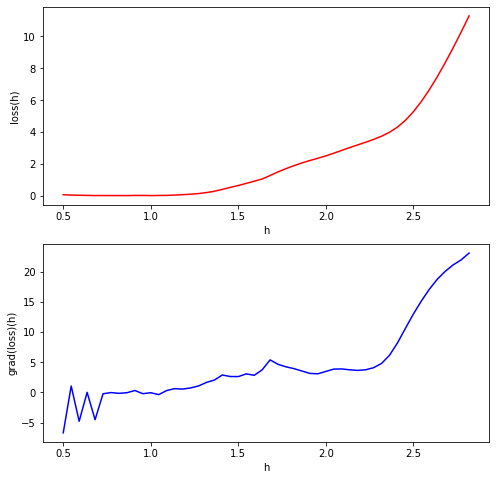

In [23]:
end = -48
makeplots(slog[:end].transpose(), bandwidth_grid[:end], style="")

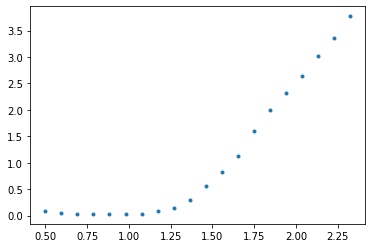

In [40]:
plt.plot(bandwidth_grid[:20], slog[:20], ".")
# plt.xscale("log")
# plt.yscale("log")

# 2-d bandwidth

In [2]:
n=100
d=2
stepsize = 0.01
n_iter_max = 500 # 100 slightly to little, this should be all right
bandwidth = np.array([1, 1])

from svgd import get_bandwidth

from jax.scipy.stats import multivariate_normal
mean = np.array([1,2])
cov = np.array([[1,1], [1, 2]])
assert utils.is_pd(cov)
logp = lambda x: multivariate_normal.logpdf(x, mean, cov)


svgd_fix = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=False, get_bandwidth=None, particle_shape=(n, d))
svgd_ada = SVGD(logp=logp, n_iter_max=n_iter_max, adaptive_kernel=True,  get_bandwidth=get_bandwidth, particle_shape=(n, d))

svgd_stepsize = stepsize

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

# Optimize

In [4]:
h = [10, 10]
stepsize = 0.01
n_steps = 30
hout, log = svgd_fix.optimize_bandwidth(h, stepsize, n_steps)
print(hout)

  0%|          | 0/30 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 3.567460536956787 seconds.


  0%|          | 0/30 [00:32<?, ?it/s]


KeyboardInterrupt: 

In [4]:
h = 3
stepsize = 0.01
n_steps = 30
hout, log = svgd_fix.optimize_bandwidth(h, stepsize, n_steps, gradient_clip_threshold=10)
print(hout)

  0%|          | 0/30 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 3.7440717220306396 seconds.


100%|██████████| 30/30 [01:54<00:00,  3.81s/it]

1.4934164


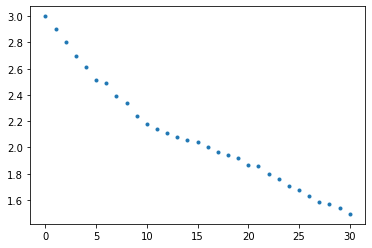

In [6]:
plt.plot(log, ".")

In [5]:
h = [3, 4]
stepsize = 0.01
n_steps = 30
hout, log = svgd_fix.optimize_bandwidth(h, stepsize, n_steps)
print(hout)
plt.plot(log)

  0%|          | 0/30 [00:00<?, ?it/s]

JIT COMPILING...
Done compiling in 3.478790521621704 seconds.


  0%|          | 0/30 [00:33<?, ?it/s]


Exception: Gradient is NaN. Last non-NaN value of bandwidth was [3, 4]